## **CSE 5095: Social Media Mining and Analysis**
**Fall 2024, Assignment #2, 200 points**

In this assignment, we will explore the statistical feature extraction methods from the text of the observations (post or comments), and use these features along with those extracted from the quantitative metadata in Assignment #1 to build a classification framework to separate the observations according to the two subreddits. In that sense, the subreddits serve as weak labels of the observations.

**Task 1: Word Clouds (30 points)**

Pre-process the text of the observations (posts or comments depending on your data set). If your observations consist of posts, then use the post text as well as the title, by concatenating both these fields into a single sentence. Build two word clouds, one per subreddit from the pre-processed texts. The two word clouds, one for each subreddit, should be sufficiently distinct from each other, and through simple visualization it should be possible to map a word cloud to its respective subreddit. Therefore, to build these distinct word clouds, it will be necessary to remove as many words/tokens as possible that are common or overlapping between the two subreddits. This will be essentially an iterative process.

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

Initial data shape: (3274, 25)

Missing values in text columns:
post_title           0
post_self_text    2565
self_text            0
dtype: int64


C:\Users\mso21001\AppData\Local\Temp\ipykernel_28068\1777179382.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=ax, palette='viridis')
C:\Users\mso21001\AppData\Local\Temp\ipykernel_28068\1777179382.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, ax=ax, palette='viridis')



Most distinctive words in each subreddit:

r/science top 20 words:
climate: 0.0728
change: 0.0420
fossil: 0.0274
people: 0.0243
emissions: 0.0234
new: 0.0219
just: 0.0214
global: 0.0214
oil: 0.0213
carbon: 0.0190
gas: 0.0184
crisis: 0.0182
fuel: 0.0181
energy: 0.0176
like: 0.0167
warming: 0.0166
fuels: 0.0163
world: 0.0162
cop: 0.0148
dont: 0.0146

r/action top 20 words:
climate: 0.0831
change: 0.0518
action: 0.0377
post: 0.0301
people: 0.0285
thread: 0.0280
current: 0.0271
discussion: 0.0265
energy: 0.0264
carbon: 0.0261
just: 0.0258
concerns: 0.0258
like: 0.0250
dont: 0.0228
use: 0.0220
emissions: 0.0208
new: 0.0198
things: 0.0197
does: 0.0191
need: 0.0191


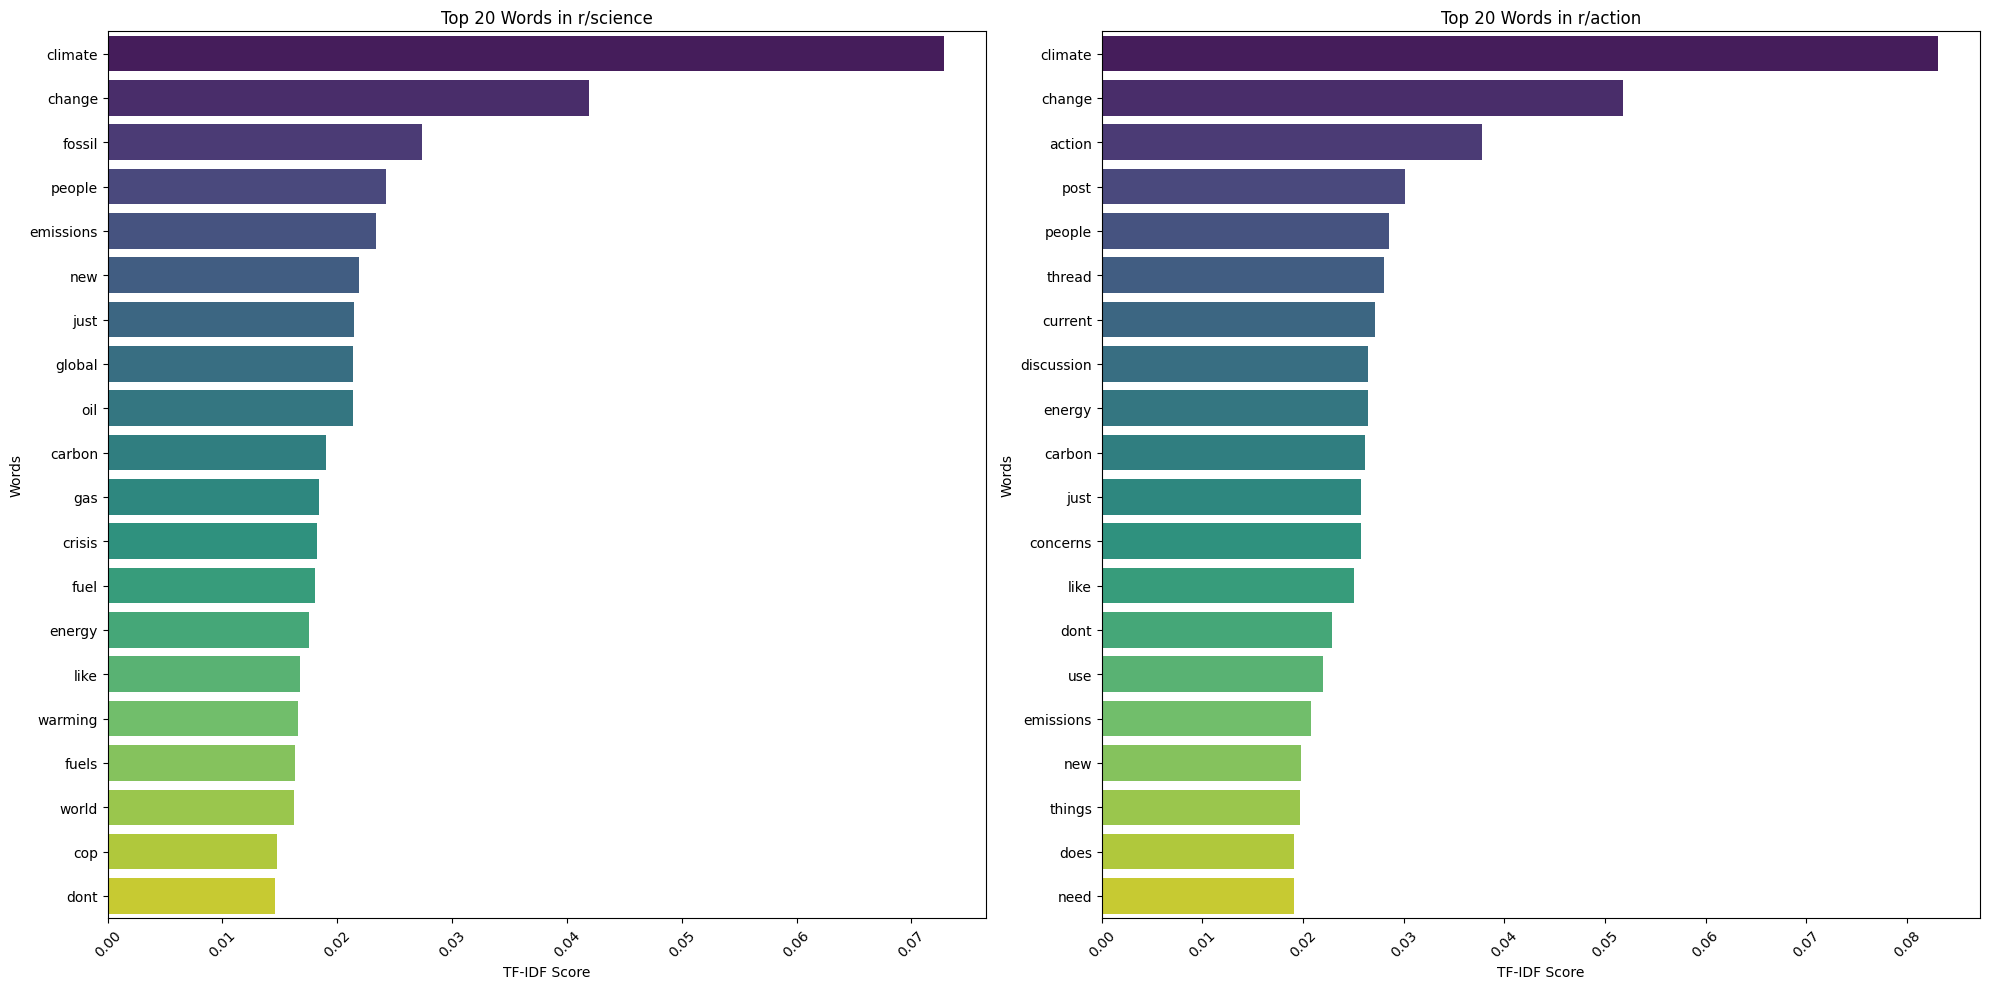

In [3]:
def preprocess_text(text):
    if pd.isna(text) or text is None:
        return ''
    
    text = str(text).lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    text = ' '.join(text.split())
    
    return text

def combine_text_fields(row):
    fields = [
        str(row['post_title']) if not pd.isna(row['post_title']) else '',
        str(row['post_self_text']) if not pd.isna(row['post_self_text']) else '',
        str(row['self_text']) if not pd.isna(row['self_text']) else ''
    ]
    return ' '.join(field for field in fields if field)

def get_top_words_per_subreddit(df, n_words=50, min_df=5):

    df['combined_text'] = df.apply(combine_text_fields, axis=1)
    df['combined_text'] = df['combined_text'].apply(preprocess_text)

    df = df[df['combined_text'].str.len() > 0].copy()
    
    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        min_df=min_df,
        token_pattern=r'\b[a-zA-Z]{3,}\b'
    )
    
    subreddit_top_words = {}
    
    for subreddit in df['subreddit'].unique():
        subreddit_texts = df[df['subreddit'] == subreddit]['combined_text']
        
        if len(subreddit_texts) == 0:
            continue
            
        try:
            tfidf_matrix = tfidf.fit_transform(subreddit_texts)
            feature_names = np.array(tfidf.get_feature_names_out())
            
            mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
            
            top_indices = mean_tfidf.argsort()[-n_words:][::-1]
            
            subreddit_top_words[subreddit] = {
                'words': feature_names[top_indices],
                'scores': mean_tfidf[top_indices]
            }
        except ValueError as e:
            print(f"Error processing subreddit {subreddit}: {str(e)}")
            continue
    
    return subreddit_top_words

def plot_word_importance(top_words_dict, n_words=20):
    n_subreddits = len(top_words_dict)
    fig, axes = plt.subplots(1, n_subreddits, figsize=(20, 10))
    
    for idx, (subreddit, data) in enumerate(top_words_dict.items()):
        words = data['words'][:n_words]
        scores = data['scores'][:n_words]
        
        ax = axes[idx] if n_subreddits > 1 else axes
        sns.barplot(x=scores, y=words, ax=ax, palette='viridis')
        ax.set_title(f'Top {n_words} Words in r/{subreddit}')
        ax.set_xlabel('TF-IDF Score')
        ax.set_ylabel('Words')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def analyze_subreddit_texts(df, n_words=20):
    print("Initial data shape:", df.shape)
    print("\nMissing values in text columns:")
    print(df[['post_title', 'post_self_text', 'self_text']].isna().sum())
    
    top_words_dict = get_top_words_per_subreddit(df, min_df=5)
    fig = plot_word_importance(top_words_dict, n_words)
    
    print("\nMost distinctive words in each subreddit:")
    for subreddit, data in top_words_dict.items():
        print(f"\nr/{subreddit} top {n_words} words:")
        for word, score in zip(data['words'][:n_words], data['scores'][:n_words]):
            print(f"{word}: {score:.4f}")
    
    return top_words_dict, fig

df = pd.read_csv('project10.csv')

top_words_dict, fig = analyze_subreddit_texts(df)
plt.show()

**Task 2: TF-IDF Feature Vectors (20 points)**

Build feature vectors for the pre-processed texts from Task 1 by computing the TF-IDF scores of each feature. Recall, that the number of features is equal to the number of unique words/tokens in the vocabulary that remain after the pre-processing steps have been applied, including the removal of the common stop words and overlapping words. What are the dimensions of each feature vector? Choose two most prominent words from each subreddit, by considering the word clouds in Task 1. This will result in four words, and compute pairwise cosine similarity between the TF-IDF vectors of these four words.


Feature Vector Dimensions:
Number of documents: 3274
Number of features (unique words): 4257


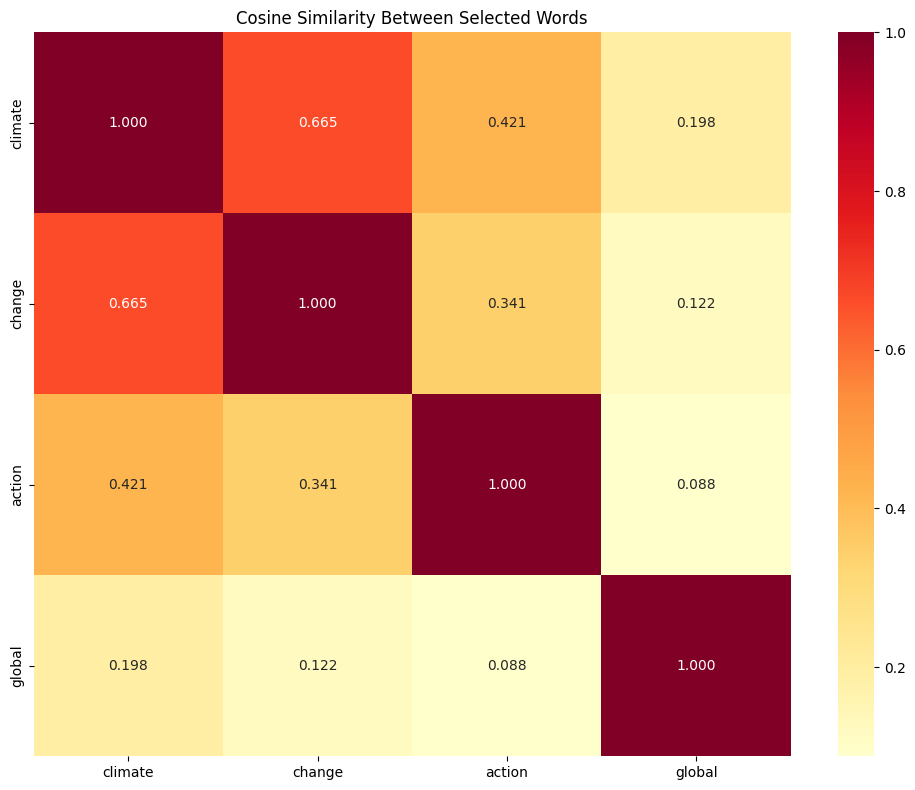


Pairwise Cosine Similarities:
          climate    change    action    global
climate  1.000000  0.664641  0.421297  0.197924
change   0.664641  1.000000  0.340906  0.122489
action   0.421297  0.340906  1.000000  0.087749
global   0.197924  0.122489  0.087749  1.000000

Mean similarity score: 0.3058341321943951
Max similarity score: 0.6646408075523971
Min similarity score: 0.0877488267546772


In [4]:
from sklearn.metrics.pairwise import cosine_similarity


def build_tfidf_vectors(df):
    """
    Build TF-IDF vectors from preprocessed text
    """
    # Combine and preprocess text
    df['combined_text'] = df.apply(combine_text_fields, axis=1)
    df['combined_text'] = df['combined_text'].apply(preprocess_text)
    
    # Remove empty texts
    df = df[df['combined_text'].str.len() > 0].copy()
    
    # Initialize and fit TF-IDF vectorizer
    tfidf = TfidfVectorizer(
        max_features=None,  # Keep all features
        stop_words='english',
        min_df=5,  # Minimum document frequency
        token_pattern=r'\b[a-zA-Z]{3,}\b'  # Only words with 3+ letters
    )
    
    # Fit and transform the text data
    tfidf_matrix = tfidf.fit_transform(df['combined_text'])
    
    return tfidf, tfidf_matrix, df

def analyze_word_similarities(tfidf, tfidf_matrix, selected_words):
    """
    Compute cosine similarities between selected words
    """
    # Get feature names and their indices
    feature_names = tfidf.get_feature_names_out()
    word_indices = {}
    
    # Find indices of selected words
    for word in selected_words:
        try:
            word_indices[word] = np.where(feature_names == word)[0][0]
        except IndexError:
            print(f"Warning: Word '{word}' not found in vocabulary")
            return None
    
    # Extract TF-IDF vectors for selected words
    word_vectors = tfidf_matrix.T[list(word_indices.values())]
    
    # Compute pairwise cosine similarities
    similarities = cosine_similarity(word_vectors)
    
    return similarities, list(word_indices.keys())

def plot_similarities(similarities, words):
    """
    Create a heatmap of word similarities
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities, 
                annot=True, 
                fmt='.3f', 
                cmap='YlOrRd',
                xticklabels=words,
                yticklabels=words)
    plt.title('Cosine Similarity Between Selected Words')
    plt.tight_layout()
    return plt.gcf()

tfidf, tfidf_matrix, processed_df = build_tfidf_vectors(df)

# Print dimensions of feature vectors
n_documents, n_features = tfidf_matrix.shape
print(f"\nFeature Vector Dimensions:")
print(f"Number of documents: {n_documents}")
print(f"Number of features (unique words): {n_features}")

# Selected prominent words from each subreddit
# Replace these with your selected words based on Task 1
selected_words = ['climate', 'change', 'action', 'global']  # Example words

# Compute similarities
similarities, found_words = analyze_word_similarities(tfidf, tfidf_matrix, selected_words)

if similarities is not None:
    # Plot similarities
    fig = plot_similarities(similarities, found_words)
    plt.show()
    
    # Print similarity matrix
    print("\nPairwise Cosine Similarities:")
    similarity_df = pd.DataFrame(similarities, 
                               index=found_words,
                               columns=found_words)
    print(similarity_df)
    
    # Print additional statistics
    print("\nMean similarity score:", np.mean(similarities[np.triu_indices_from(similarities, k=1)]))
    print("Max similarity score:", np.max(similarities[np.triu_indices_from(similarities, k=1)]))
    print("Min similarity score:", np.min(similarities[np.triu_indices_from(similarities, k=1)]))

**Task 3: ML Models (60 points)** 

Split the entire data set into two partitions – train (80%) and test (20%). Use the feature vectors of the observations from the training data set to train the following four ML classifiers: a) Logistic Regression, b) Random Forest, c) Naïve Bayes, and d) Support Vector Machine to classify the observations into two subreddits. Evaluate the performance of each classifier using four metrics – accuracy, precision, recall and F1-score. 


Splitting data into train and test sets...
Building TF-IDF features...

Feature dimensions:
Training set: (2619, 3657)
Test set: (655, 3657)

Training and evaluating models...

Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      action       0.89      0.51      0.65       208
     science       0.81      0.97      0.88       447

    accuracy                           0.82       655
   macro avg       0.85      0.74      0.77       655
weighted avg       0.84      0.82      0.81       655


Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

      action       0.91      0.47      0.62       208
     science       0.80      0.98      0.88       447

    accuracy                           0.82       655
   macro avg       0.85      0.72      0.75       655
weighted avg       0.83      0.82      0.80       655


Training Naive Bay

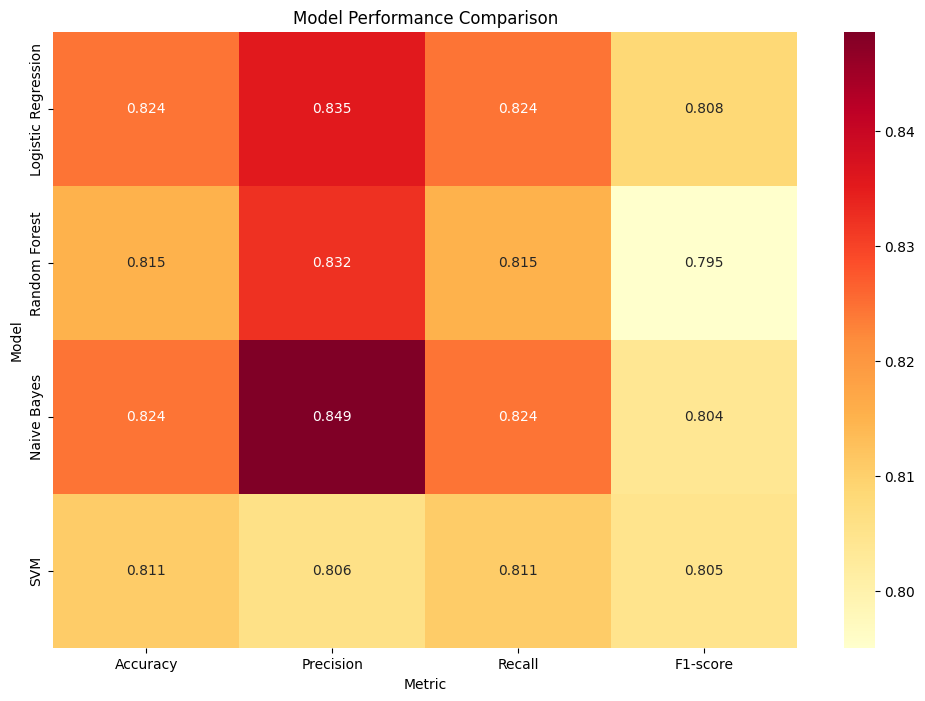

<Figure size 1200x600 with 0 Axes>

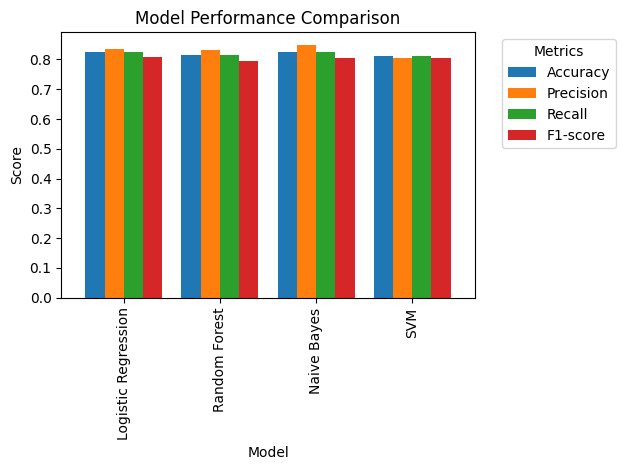


Summary of Results:
                     Accuracy  Precision  Recall  F1-score
Logistic Regression     0.824      0.835   0.824     0.808
Random Forest           0.815      0.832   0.815     0.795
Naive Bayes             0.824      0.849   0.824     0.804
SVM                     0.811      0.806   0.811     0.805

Best Models:
Accuracy: Logistic Regression (0.824)
Precision: Naive Bayes (0.849)
Recall: Logistic Regression (0.824)
F1-score: Logistic Regression (0.808)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def prepare_data(df):
    """
    Prepare data for classification
    """
    # Combine and preprocess text
    df['combined_text'] = df.apply(combine_text_fields, axis=1)
    df['combined_text'] = df['combined_text'].apply(preprocess_text)
    
    # Remove empty texts
    df = df[df['combined_text'].str.len() > 0].copy()
    
    return df

def build_features(train_texts, test_texts):
    """
    Build TF-IDF features for train and test sets
    """
    tfidf = TfidfVectorizer(
        max_features=5000,  # Limit features to prevent overfitting
        min_df=5,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{3,}\b'
    )
    
    # Fit on training data only to prevent data leakage
    X_train = tfidf.fit_transform(train_texts)
    X_test = tfidf.transform(test_texts)
    
    return X_train, X_test, tfidf

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple classifiers
    """
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Naive Bayes': MultinomialNB(),
        'SVM': LinearSVC(max_iter=1000)
    }
    
    # Store results
    results = {}
    
    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        clf.fit(X_train, y_train)
        
        # Make predictions
        y_pred = clf.predict(X_test)
        
        # Calculate metrics
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-score': f1_score(y_test, y_pred, average='weighted')
        }
        
        results[name] = metrics
        
        # Print detailed classification report
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred))
    
    return results

def plot_results(results):
    """
    Create visualizations of model performance
    """
    # Prepare data for plotting
    metrics_df = pd.DataFrame(results).T
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Model Performance Comparison')
    plt.ylabel('Model')
    plt.xlabel('Metric')
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

df_processed = prepare_data(df)

# Split into train and test sets
print("\nSplitting data into train and test sets...")
train_df, test_df = train_test_split(
    df_processed,
    test_size=0.2,
    random_state=42,
    stratify=df_processed['subreddit']
)

# Build features
print("Building TF-IDF features...")
X_train, X_test, tfidf = build_features(
    train_df['combined_text'],
    test_df['combined_text']
)

# Get labels
y_train = train_df['subreddit']
y_test = test_df['subreddit']

# Print feature dimen sions
print(f"\nFeature dimensions:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Train and evaluate models
print("\nTraining and evaluating models...")
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Plot results
plot_results(results)
plt.show()

# Print summary
print("\nSummary of Results:")
results_df = pd.DataFrame(results).T
print(results_df.round(3))

# Find best model for each metric
print("\nBest Models:")
for metric in results_df.columns:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.3f})")

**Task 4: Exploring Performance vs. Run-Time Tradeoffs (45 points)**

Even after eliminating stop words and other overlapping words, you will find that the size of the vocabulary is still significantly large, in the tens of thousands. It is highly likely that only a fraction of this vocabulary is contributing towards the actual classification. To make matters worse, retaining the entire vocabulary increases the training time, without any noticeable performance benefits. In this task, you will prune the size of the vocabulary to various levels and compute the performance metrics and note the run time. For example, if the size of your vocabulary is 65,000 try pruning it down to 60,000, 50,000 and so on, all the way to 5000. Tabulate the four performance metrics and the run times for each level of pruning. Do you observe that the performance drops dramatically beyond a certain degree of pruning? What performance vs. run-time tradeoff would you consider acceptable? Does pruning affect different performance metrics differently? Explore these tradeoffs using the random forest model.

Starting vocabulary pruning analysis...

Analyzing vocabulary size: 5000
Runtime: 1.28 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 10000
Runtime: 1.32 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 20000
Runtime: 1.28 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 30000
Runtime: 1.27 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 40000
Runtime: 1.25 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 50000
Runtime: 1.27 seconds
Accuracy: 0.8153

Analyzing vocabulary size: 60000
Runtime: 1.25 seconds
Accuracy: 0.8153


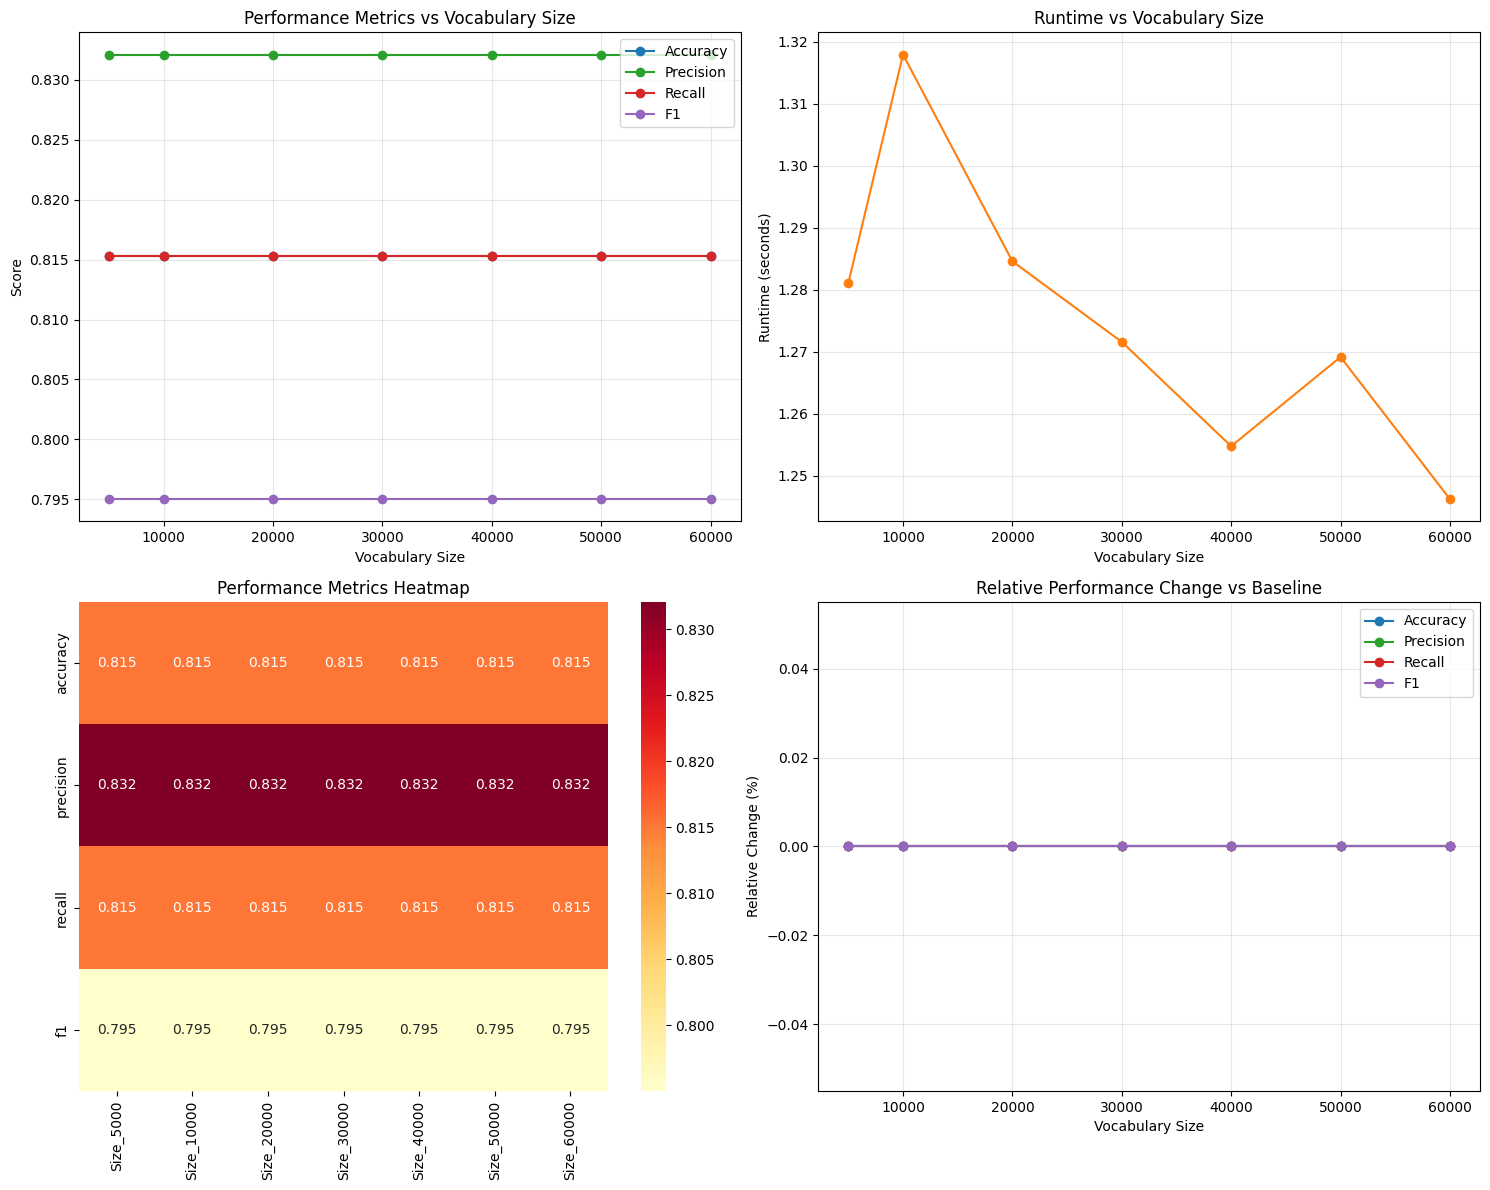


Detailed Results:


,vocab_size,accuracy,precision,recall,f1,runtime
0,5000,0.8153,0.8321,0.8153,0.795,1.2811
1,10000,0.8153,0.8321,0.8153,0.795,1.3180
2,20000,0.8153,0.8321,0.8153,0.795,1.2846
3,30000,0.8153,0.8321,0.8153,0.795,1.2716
4,40000,0.8153,0.8321,0.8153,0.795,1.2547
5,50000,0.8153,0.8321,0.8153,0.795,1.2691
6,60000,0.8153,0.8321,0.8153,0.795,1.2462



Analysis of Optimal Points:

Best Performance Point:
Vocabulary Size: 5000.0
Accuracy: 0.8153
Runtime: 1.28 seconds

Fastest Runtime Point:
Vocabulary Size: 60000.0
Accuracy: 0.8153
Runtime: 1.25 seconds

Relative Performance Change from Maximum Vocabulary Size:


,vocab_size,accuracy_change,precision_change,recall_change,f1_change
0,5000,0.0,0.0,0.0,0.0
1,10000,0.0,0.0,0.0,0.0
2,20000,0.0,0.0,0.0,0.0
3,30000,0.0,0.0,0.0,0.0
4,40000,0.0,0.0,0.0,0.0
5,50000,0.0,0.0,0.0,0.0
6,60000,0.0,0.0,0.0,0.0


In [6]:
import time 

# Set default matplotlib style
plt.style.use('default')

# Define analysis functions
def analyze_vocab_pruning(df, vocab_sizes, random_state=42):
    """
    Analyze the impact of vocabulary pruning on model performance and runtime
    """
    # Prepare data
    X = df['combined_text']
    y = df['subreddit']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    results = []
    
    for vocab_size in vocab_sizes:
        print(f"\nAnalyzing vocabulary size: {vocab_size}")
        
        # Initialize vectorizer with current vocab size
        vectorizer = TfidfVectorizer(
            max_features=vocab_size,
            min_df=5,
            stop_words='english',
            token_pattern=r'\b[a-zA-Z]{3,}\b'
        )
        
        # Transform data and time the process
        start_time = time.time()
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)
        
        # Initialize and train Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        rf.fit(X_train_tfidf, y_train)
        
        # Make predictions
        y_pred = rf.predict(X_test_tfidf)
        
        # Calculate total runtime
        total_time = time.time() - start_time
        
        # Calculate metrics
        metrics = {
            'vocab_size': vocab_size,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average='weighted'),
            'recall': recall_score(y_test, y_pred, average='weighted'),
            'f1': f1_score(y_test, y_pred, average='weighted'),
            'runtime': total_time
        }
        
        results.append(metrics)
        
        print(f"Runtime: {total_time:.2f} seconds")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
    
    return pd.DataFrame(results)

def plot_pruning_results(results_df):
    """
    Create visualizations for pruning analysis results
    """
    # Create figure and subplots with adjusted size
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot metrics vs vocabulary size
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    colors = ['#1f77b4', '#2ca02c', '#d62728', '#9467bd']  # Default matplotlib colors
    
    for metric, color in zip(metrics, colors):
        ax1.plot(results_df['vocab_size'], results_df[metric], 
                marker='o', label=metric.capitalize(), color=color)
    
    ax1.set_xlabel('Vocabulary Size')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics vs Vocabulary Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot runtime vs vocabulary size
    ax2.plot(results_df['vocab_size'], results_df['runtime'], 
            marker='o', color='#ff7f0e')  # Orange
    ax2.set_xlabel('Vocabulary Size')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_title('Runtime vs Vocabulary Size')
    ax2.grid(True, alpha=0.3)
    
    # Create heatmap of metrics
    metrics_heatmap = results_df[metrics].T
    metrics_heatmap.columns = [f'Size_{size}' for size in results_df['vocab_size']]
    sns.heatmap(metrics_heatmap, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax3)
    ax3.set_title('Performance Metrics Heatmap')
    
    # Calculate relative performance change
    relative_change = results_df[metrics].div(results_df[metrics].iloc[0]) * 100 - 100
    
    for metric, color in zip(metrics, colors):
        ax4.plot(results_df['vocab_size'], relative_change[metric], 
                marker='o', label=metric.capitalize(), color=color)
    
    ax4.set_xlabel('Vocabulary Size')
    ax4.set_ylabel('Relative Change (%)')
    ax4.set_title('Relative Performance Change vs Baseline')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Run the analysis
print("Starting vocabulary pruning analysis...")
vocab_sizes = [5000, 10000, 20000, 30000, 40000, 50000, 60000]
results_df = analyze_vocab_pruning(df, vocab_sizes)

# Create and display visualizations
fig = plot_pruning_results(results_df)
plt.show()

# Print detailed results
print("\nDetailed Results:")
display(results_df.round(4))

# Calculate and print optimal points
print("\nAnalysis of Optimal Points:")
max_performance = results_df.loc[results_df['accuracy'].idxmax()]
min_runtime = results_df.loc[results_df['runtime'].idxmin()]

print(f"\nBest Performance Point:")
print(f"Vocabulary Size: {max_performance['vocab_size']}")
print(f"Accuracy: {max_performance['accuracy']:.4f}")
print(f"Runtime: {max_performance['runtime']:.2f} seconds")

print(f"\nFastest Runtime Point:")
print(f"Vocabulary Size: {min_runtime['vocab_size']}")
print(f"Accuracy: {min_runtime['accuracy']:.4f}")
print(f"Runtime: {min_runtime['runtime']:.2f} seconds")

# Calculate and display relative performance changes
baseline = results_df.iloc[-1]
relative_perf = results_df.copy()
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    relative_perf[f'{metric}_change'] = (
        (results_df[metric] - baseline[metric]) / baseline[metric] * 100
    )

print("\nRelative Performance Change from Maximum Vocabulary Size:")
display(relative_perf[['vocab_size'] + 
                     [f'{m}_change' for m in ['accuracy', 'precision', 'recall', 'f1']]].round(2))

**Task 5: Augmenting with Metadata Features (45 points)**

Once you have determined the optimal size of the vocabulary in Task 4, augment these pruned feature vectors with the quantitative metadata from Assignment #1. Normalize these quantitative features (using min-max scaling, or mean-variance standardization) and run the four classifiers again. Compare the performance of the classifiers with the augmented feature vectors that include the quantitative metadata with the performance from Task 4. Does including the quantitative metadata affect all the four performance metrics to the same extent?

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
from sklearn.preprocessing import MinMaxScaler

def prepare_features(df, optimal_vocab_size, metadata_columns, scaler_type='standard'):
    """
    Prepare text and metadata features
    
    Parameters:
    df: DataFrame containing text and metadata
    optimal_vocab_size: Optimal vocabulary size determined from Task 4
    metadata_columns: List of metadata column names
    scaler_type: 'standard' for StandardScaler or 'minmax' for MinMaxScaler
    """
    # Prepare text features
    vectorizer = TfidfVectorizer(
        max_features=optimal_vocab_size,
        min_df=5,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{3,}\b'
    )
    
    # Initialize scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    return vectorizer, scaler

def train_evaluate_model(clf, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a single classifier
    """
    start_time = time.time()
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Calculate runtime
    runtime = time.time() - start_time
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'runtime': runtime
    }
    
    return metrics

def compare_models(df, optimal_vocab_size, metadata_columns, random_state=42):
    """
    Compare models with and without metadata features
    """
    # Prepare data
    X_text = df['combined_text']
    X_meta = df[metadata_columns]
    y = df['subreddit']
    
    # Split data
    X_text_train, X_text_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
        X_text, X_meta, y, test_size=0.2, random_state=random_state, stratify=y
    )
    
    # Prepare features
    vectorizer, scaler = prepare_features(df, optimal_vocab_size, metadata_columns)
    
    # Transform text features
    X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
    X_text_test_tfidf = vectorizer.transform(X_text_test)
    
    # Transform metadata features
    X_meta_train_scaled = scaler.fit_transform(X_meta_train)
    X_meta_test_scaled = scaler.transform(X_meta_test)
    
    # Combine features
    X_train_combined = hstack([X_text_train_tfidf, X_meta_train_scaled])
    X_test_combined = hstack([X_text_test_tfidf, X_meta_test_scaled])
    
    # Initialize classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Naive Bayes': MultinomialNB(),
        'SVM': LinearSVC(max_iter=1000)
    }
    
    # Store results
    results = {
        'text_only': {},
        'with_metadata': {}
    }
    
    # Evaluate models with text features only
    print("\nEvaluating models with text features only...")
    for name, clf in classifiers.items():
        results['text_only'][name] = train_evaluate_model(
            clf, X_text_train_tfidf, X_text_test_tfidf, y_train, y_test
        )
    
    # Evaluate models with combined features
    print("\nEvaluating models with text and metadata features...")
    for name, clf in classifiers.items():
        results['with_metadata'][name] = train_evaluate_model(
            clf, X_train_combined, X_test_combined, y_train, y_test
        )
    
    return results

def plot_comparison(results):
    """
    Create visualizations comparing model performance
    """
    # Prepare data for plotting
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = list(results['text_only'].keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    # Plot each metric
    for idx, metric in enumerate(metrics):
        text_scores = [results['text_only'][model][metric] for model in models]
        meta_scores = [results['with_metadata'][model][metric] for model in models]
        
        x = np.arange(len(models))
        width = 0.35
        
        axes[idx].bar(x - width/2, text_scores, width, label='Text Only')
        axes[idx].bar(x + width/2, meta_scores, width, label='With Metadata')
        
        axes[idx].set_title(f'{metric.capitalize()} Comparison')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(models, rotation=45)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def calculate_relative_improvement(results):
    """
    Calculate relative improvement from adding metadata
    """
    improvements = {}
    
    for model in results['text_only'].keys():
        improvements[model] = {}
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            base_score = results['text_only'][model][metric]
            meta_score = results['with_metadata'][model][metric]
            rel_improvement = ((meta_score - base_score) / base_score) * 100
            improvements[model][metric] = rel_improvement
    
    return pd.DataFrame(improvements).T

# Run the analysis
print("Starting augmented features analysis...")

# Define metadata columns from Assignment #1
metadata_columns = [
    'post_score', 'post_upvote_ratio', 'post_thumbs_ups', 
]


# Use the optimal vocabulary size from Task 4
optimal_vocab_size = 20000  # Replace with your optimal size

# Run comparison
results = compare_models(df, optimal_vocab_size, metadata_columns)

# Create and display visualizations
fig = plot_comparison(results)
plt.show()

# Print detailed results
print("\nDetailed Results:")
print("\nText Features Only:")
for model, metrics in results['text_only'].items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

print("\nWith Metadata Features:")
for model, metrics in results['with_metadata'].items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Calculate and display relative improvements
improvements_df = calculate_relative_improvement(results)
print("\nRelative Improvement (%) from Adding Metadata:")
display(improvements_df.round(2))

# Create heatmap of improvements
plt.figure(figsize=(10, 6))
sns.heatmap(improvements_df, annot=True, fmt='.2f', cmap='RdYlGn', center=0)
plt.title('Relative Improvement (%) from Adding Metadata')
plt.tight_layout()
plt.show()

Starting augmented features analysis...

Evaluating models with text features only...

Evaluating models with text and metadata features...


ValueError: Negative values in data passed to MultinomialNB (input X)